#  Chapter 3, demo 6

Bayesian Data Analysis, 3rd ed

Illustrate posterior inference for Bioassay data (BDA3 p. 74-).

#### Instructions for exercise (3.11 in BDA3)
- Check that the range and spacing of A and B are sensible for the 
  alternative prior
- Compute the log-posterior in a grid
- Scale the log-posterior by subtracting its maximum value before
  exponentiating (think why this is useful)
- Exponentiate
- Normalize the posterior
- Use 2D grid sampling 
- In addition to the plots, report p(beta>0|x,y)

In [1]:
import numpy as np

from scipy.special import expit  # aka logistic
import matplotlib.pyplot as plt
import preliz as pz
pz.style.use('preliz-doc')

In [2]:
# seed a random state
rng = np.random.RandomState(0)

In [3]:
# data
x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])

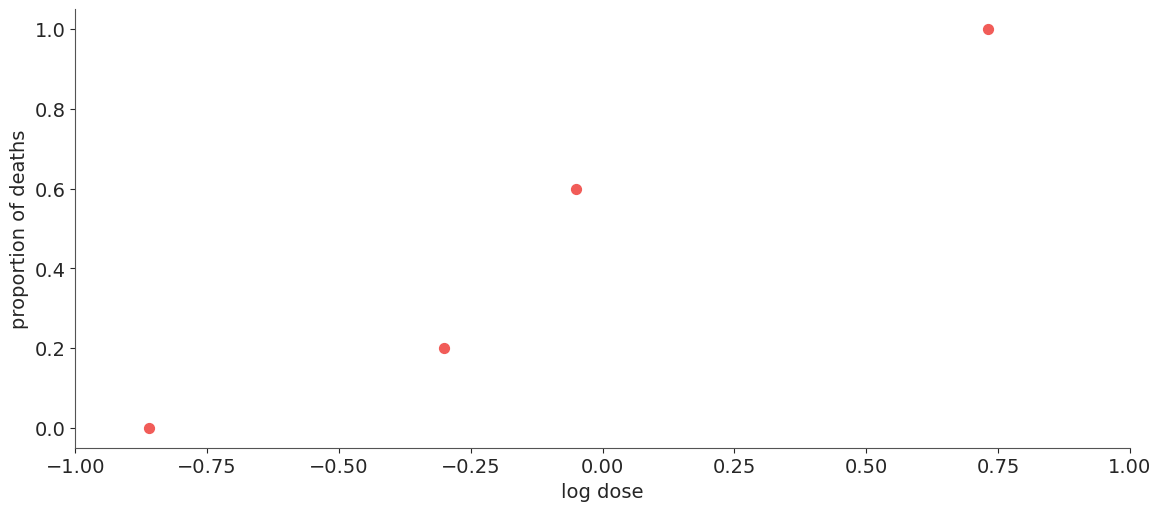

In [4]:
# plot the data
plt.scatter(x, y/n, 50, color='C2')
plt.xlim((-1, 1))
plt.xlabel('log dose')
plt.ylabel('proportion of deaths');

In [5]:
# compute the posterior density in grid
#  - usually should be computed in logarithms!
#  - with alternative prior, check that range and spacing of A and B
#    are sensible
A = np.linspace(-4, 8, 100)
B = np.linspace(-10, 40, 100)
ilogit_abx = 1 / (np.exp(-(A[:,None] + B[:,None,None] * x)) + 1)
p = np.prod(ilogit_abx**y * (1 - ilogit_abx)**(n - y), axis=2)

The following demonstrates an alternative "bad" way of calcuting the posterior density p in a for loop. The vectorised statement above is numerically more efficient. In this small example however, it would not matter that much.

```python
p = np.empty((len(B),len(A))) # allocate space
for i in range(len(A)):
    for j in range(len(B)):
        ilogit_abx_ij = (1 / (np.exp(-(A[i] + B[j] * x)) + 1))
        p[j,i] = np.prod(ilogit_abx_ij**y * (1 - ilogit_abx_ij)**(n - y))
```

N.B. the vectorised expression could be made even more efficient, e.g. by optimising memory usage with in-place statements. However, it would result in a less readable code and it is not necessary here.

In [6]:
# sample from the grid
nsamp = 1000
samp_indices = np.unravel_index(
    rng.choice(p.size, size=nsamp, p=p.ravel()/np.sum(p)),
    p.shape
)
samp_A = A[samp_indices[1]]
samp_B = B[samp_indices[0]]
# add random jitter, see BDA3 p. 76
samp_A += (rng.rand(nsamp) - 0.5) * (A[1]-A[0])
samp_B += (rng.rand(nsamp) - 0.5) * (B[1]-B[0])

# samples of LD50 conditional beta > 0
bpi = samp_B > 0
samp_ld50 = -samp_A[bpi]/samp_B[bpi]

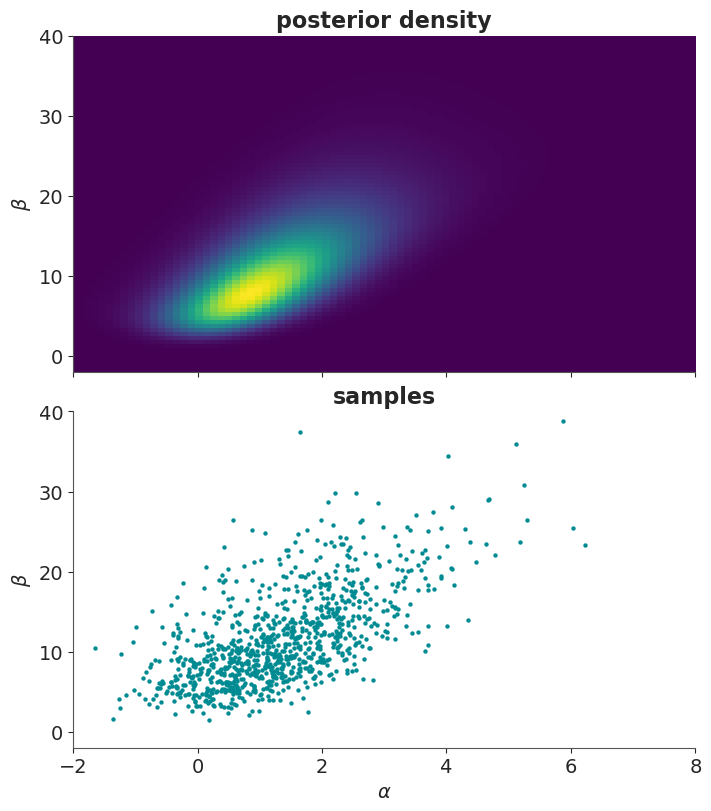

In [7]:
_, (ax_post, ax_samps) = plt.subplots(2, 1, figsize=(7, 8), sharex=True)
xlim, ylim = [-2, 8], [-2, 40]

# Posterior density
ax_post.imshow(
    p, origin="lower", aspect="auto",
    extent=(A[0], A[-1], B[0], B[-1])
)
ax_post.set(
    xlim=xlim, ylim=ylim,
    ylabel=r"$\beta$", title="posterior density"
)
ax_post.grid(False)

# Posterior samples
ax_samps.scatter(samp_A, samp_B, s=10, linewidths=0)
ax_samps.set(
    xlim=xlim, ylim=ylim,
    xlabel=r"$\alpha$", ylabel=r"$\beta$", title="samples"
);


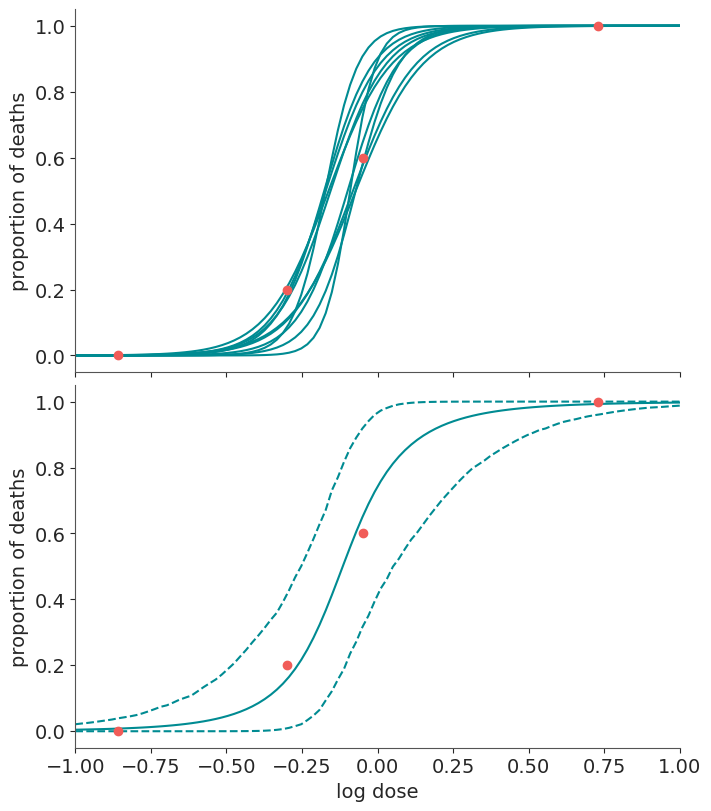

In [8]:
# Sample posterior probabilities
xt = np.linspace(-1, 1, 100)
fs = expit(samp_A[:, None] + samp_B[:, None]*xt)

fig, (ax_0, ax_1) = plt.subplots(
    2, 1, figsize=(7, 8), sharex=True
)

# First 10 sample curves
ax_0.plot(xt, fs[:10].T, color="C0")
ax_0.plot(x, y/n, "C2o")
ax_0.set(xlim=(-1, 1), ylabel="proportion of deaths")

# Posterior mean and 5–95% interval
mean_fs = fs.mean(axis=0)
ci_fs = np.percentile(fs, [5, 95], axis=0)

ax_1.plot(xt, mean_fs, color="C0")
ax_1.plot(xt, ci_fs.T, "C0--")
ax_1.plot(x, y/n, "C2o")
ax_1.set(xlim=(-1, 1), xlabel="log dose", ylabel="proportion of deaths");


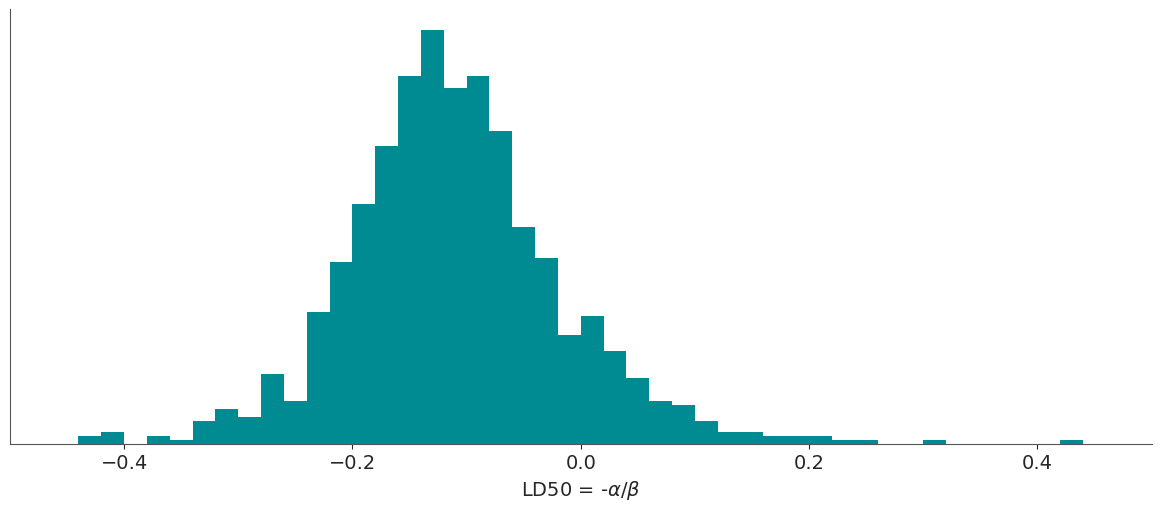

In [9]:
# plot the histogram of LD50
_, ax = plt.subplots()
ax.hist(samp_ld50, np.arange(-0.5, 0.51, 0.02))
ax.set(xlim=([-0.5, 0.5]),
       yticks=[],
       xlabel=r'LD50 = -$\alpha/\beta$');